# Objetivo del notebook

Este fichero Jupyter tiene como objetivo diseñar una estructura de red convolucional, y entrenarla con el conjunto de datos procesado.

Utilizaremos este modelo como modelo base, y de hecho, permitirá servir de comparación para cuando lleve a cabo el entrenamiento de un nuevo modelo, esta vez, aplicando la estrategia de aumento de datos.

---

<br>
<br>
<br>

## Importar las librerías a utilizar

En la siguiente celda se importan todas las librerías que se utilizan en el presente fichero Jupyter.

In [1]:
# Librerías de procesamiento y manipulación de datos
import numpy as np

# Librerías de visualización
import matplotlib.pyplot as plt
import cv2 as cv

# Librerías para la construcción de la red convolucional
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Otros
import os
from tqdm import tqdm
import warnings

warnings.filterwarnings(action = "ignore")

---

<br>
<br>
<br>

## Cargando el conjunto de datos

Los datos que cargaré en este fichero Jupyter corresponden a los procesados en el fichero "data_processing.ipynb".

In [2]:
# Defino las rutas donde se alojan cada conjunto de datos
train_path = "../processed_data/train/"
val_path = "../processed_data/val/"
test_path = "../processed_data/test/"

# Instancio un objeto de la clase ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1. / 255,
)

batch_size= 20

# Defino los subconjuntos de datos con datagen.flow_from_directory()
train_data = datagen.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    classes=["not fractured", "fractured"],
    shuffle= True,
    batch_size= batch_size,
    class_mode="binary",
    color_mode = "grayscale"
)

# Defino los subconjuntos de datos con datagen.flow_from_directory()
val_data = datagen.flow_from_directory(
    directory=val_path,
    target_size=(224, 224),
    classes=["not fractured", "fractured"],
    shuffle= False,
    batch_size= batch_size,
    class_mode="binary",
    color_mode = "grayscale"  
)

# Defino los subconjuntos de datos con datagen.flow_from_directory()
test_data = datagen.flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    classes=["not fractured", "fractured"],
    shuffle= False,
    batch_size= batch_size,
    class_mode="binary",
    color_mode = "grayscale"    
)

Found 9243 images belonging to 2 classes.
Found 829 images belonging to 2 classes.
Found 524 images belonging to 2 classes.


---

<br>
<br>
<br>

## Desarrollo de la red convolucional

Voy a construir esta red convolucional inicial con una arquitectura básica para este tipo de redes, que podra servir para construir el modelo base.

In [3]:
# Construyo el modelo
model = Sequential([

    # Sección extracción
    layers.Conv2D(32, (3, 3), input_shape = (224, 224, 1), activation= "relu"),
    layers.MaxPooling2D((2, 2), padding='same'),

    layers.Conv2D(64, (3, 3), activation= "relu"),
    layers.MaxPooling2D((2, 2), padding='same'),

    layers.Conv2D(64, (3, 3), activation= "relu"),
    layers.MaxPooling2D((2, 2), padding='same'),

    # Aplano los resultados
    layers.Flatten(),

    # Sección clasificación
    layers.Dense(units = 20, activation= "relu"),
    layers.Dense(units = 1, activation= "sigmoid")
])

# Compilo el modelo
model.compile(
    optimizer= 'adam',
    loss = "binary_crossentropy",
    metrics = ['accuracy']
)

# Reviso la arquitectura del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 27, 27, 64)       0

In [4]:
# Entreno el modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('../src/trained_models/base_model.h5', save_best_only=True, monitor='val_loss')

# Entreno el modelo
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    steps_per_epoch=train_data.samples // batch_size,
    validation_steps=val_data.samples // batch_size,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
462/462 [==============================] - 11s 16ms/step - loss: 0.2561 - accuracy: 0.8921 - val_loss: 0.1960 - val_accuracy: 0.9293
Epoch 2/10
462/462 [==============================] - 7s 15ms/step - loss: 0.0446 - accuracy: 0.9849 - val_loss: 0.2148 - val_accuracy: 0.9256
Epoch 3/10
462/462 [==============================] - 7s 15ms/step - loss: 0.0239 - accuracy: 0.9918 - val_loss: 0.1155 - val_accuracy: 0.9646
Epoch 4/10
462/462 [==============================] - 7s 15ms/step - loss: 0.0151 - accuracy: 0.9944 - val_loss: 0.0666 - val_accuracy: 0.9756
Epoch 5/10
462/462 [==============================] - 7s 15ms/step - loss: 0.0157 - accuracy: 0.9951 - val_loss: 0.0720 - val_accuracy: 0.9768
Epoch 6/10
462/462 [==============================] - 7s 15ms/step - loss: 0.0028 - accuracy: 0.9990 - val_loss: 0.1290 - val_accuracy: 0.9780
Epoch 7/10
462/462 [==============================] - 7s 15ms/step - loss: 0.0276 - accuracy: 0.9920 - val_loss: 0.1206 - val_accuracy: 0.963

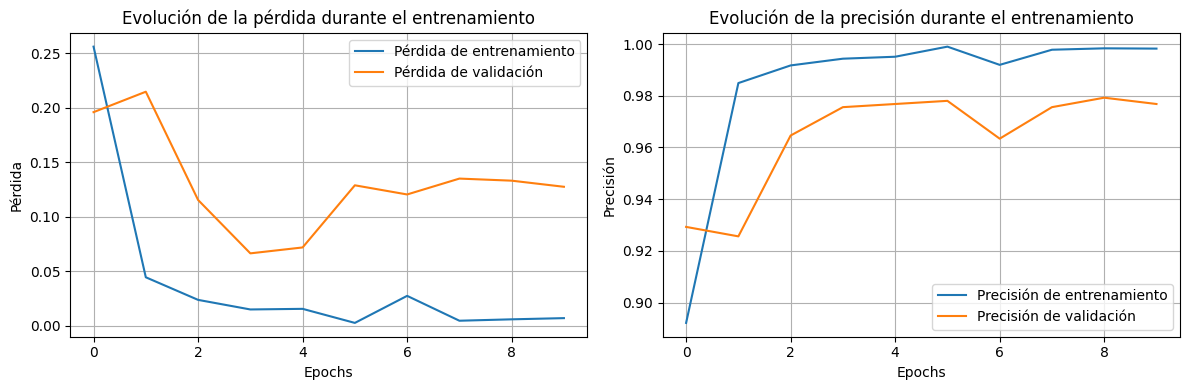

In [5]:
# Grafico la evolucion de perdida para los conjuntos de entrenamiento y prueba durante el entrenamiento
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Gráfico de pérdida
    ax1.plot(history.history['loss'], label='Pérdida de entrenamiento')
    ax1.plot(history.history['val_loss'], label='Pérdida de validación')
    ax1.set_title('Evolución de la pérdida durante el entrenamiento')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Pérdida')
    ax1.legend()
    ax1.grid(True)

    # Gráfico de precisión
    ax2.plot(history.history['accuracy'], label='Precisión de entrenamiento')
    ax2.plot(history.history['val_accuracy'], label='Precisión de validación')
    ax2.set_title('Evolución de la precisión durante el entrenamiento')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Precisión')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

---

<br>
<br>
<br>

## Validando el modelo

Tras el entrenamiento, revisamos la calidad del modelo, enfrentadolo con el conjunto de prueba, y accediendo a las metricas que reflejan las predicciones para este subset.

In [6]:
# Genero predicciones para el conjunto de prueba
y_pred = model.predict(test_data)
y_pred = [1 if p >= 0.5 else 0 for p in y_pred]

conf_matrix = confusion_matrix(test_data.classes, y_pred)
class_report = classification_report(test_data.classes, y_pred)

print(conf_matrix)
print(class_report)

27/27 [==============================] - 0s 14ms/step
[[274   0]
 [  0 250]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       274
           1       1.00      1.00      1.00       250

    accuracy                           1.00       524
   macro avg       1.00      1.00      1.00       524
weighted avg       1.00      1.00      1.00       524



In [7]:
## MÉTRICAS DE CLASIFICACIÓN

print(f"F1-Score ==> {round(f1_score(test_data.labels, y_pred), 3)}")
print(f"Recall ==> {round(recall_score(test_data.labels, y_pred), 3)}")
print(f"Precision ==> {round(precision_score(test_data.labels, y_pred), 3)}")
print(f"Accuracy ==> {round(accuracy_score(test_data.labels, y_pred), 3)}")

F1-Score ==> 1.0
Recall ==> 1.0
Precision ==> 1.0
Accuracy ==> 1.0


El modelo entrenado parece ser bastante bueno, a pesar tener una arquitectura bastante simple. Hemos obtenido una F1-Score general de en torno a 0.96, y la matriz de confusion refleja un bajo numero de predicciones incorrectas, en comparacion con todo el conjunto de datos prueba.

No obstante, podemos tomar este modelo como base, y tratar de mejorarlo iterativamente en un nuevo fichero Jupyter. Ademas, a pesar de contar ya con imagenes "modificadas", vamos a aplicar una estrategia de generacion de datos, de forma que podamos maximizar la calidad de nuestro modelo final.

In [8]:
# Guardo el modelo entrenado
base_model_path = "../src/trained_models/"
model.save(os.path.join(base_model_path, "base_model"))

print("Modelo guardado correctamente.")

INFO:tensorflow:Assets written to: ../src/trained_models/base_model\assets


INFO:tensorflow:Assets written to: ../src/trained_models/base_model\assets


Modelo guardado correctamente.


---

<br>
<br>
<br>

## UPDATE. 

Con el fin de validar una de las hipótesis inicialmente planteadas, voy a entrenar un modelo, con la misma arquitectura que el anterior, pero con un conjunto de imágenes de entrenamiento y validación bastante más limitado. Este no será un modelo que vaya a conservar, pero será útil para dar validez a la hipótesis comentada.

In [21]:
# Defino un nuevo directorio donde alojar los nuevos datasets
datasets_path = "../processed_data/"
new_datasets_path = "../limited_data/"

# Defino unas constantes como límites de imágenes para los subsets
TRAIN_LIMIT = 500
VAL_LIMIT = 100

if not os.path.exists(new_datasets_path):
    os.mkdir(new_datasets_path)

# Itero cada uno de los subconjuntos en el directorio "data/"
for subset in tqdm(os.listdir(datasets_path)):

    if subset != ".ipynb_checkpoints":

        if subset == "train":

            # Creo una nueva carpeta para cada uno de los subsets
            subset_path = os.path.join(new_datasets_path, subset)
            if not os.path.exists(subset_path):
                os.mkdir(subset_path)
    
            for class_ in os.listdir(os.path.join(datasets_path, subset)):
                
                # Creo una nueva carpeta para cada una de las clases
                class_path = os.path.join(subset_path, class_)
                if not os.path.exists(class_path):
                    os.mkdir(class_path)
    
                # Para cada una de las clases, itero sobre el listado de imágenes contenido dentro, las cargo y proceso en memoria
                n_images = 0
                for image in tqdm(os.listdir(os.path.join(datasets_path, subset, class_))):

                    if n_images == TRAIN_LIMIT:
                        break
                    
                    img_path = os.path.join(datasets_path, subset, class_, image)
                    img = cv.imread(img_path)
                    
                    if img is not None:
                        save_path = os.path.join(new_datasets_path, subset, class_, image)
                        cv.imwrite(save_path, img)
                    else:
                        print(f"Error: No se pudo cargar la imagen {img_path}")
                    n_images += 1
    
        elif subset == "val":

            # Creo una nueva carpeta para cada uno de los subsets
            subset_path = os.path.join(new_datasets_path, subset)
            if not os.path.exists(subset_path):
                os.mkdir(subset_path)
    
            for class_ in os.listdir(os.path.join(datasets_path, subset)):
                
                # Creo una nueva carpeta para cada una de las clases
                class_path = os.path.join(subset_path, class_)
                if not os.path.exists(class_path):
                    os.mkdir(class_path)
    
                # Para cada una de las clases, itero sobre el listado de imágenes contenido dentro, las cargo y proceso en memoria
                n_images = 0
                for image in tqdm(os.listdir(os.path.join(datasets_path, subset, class_))):

                    if n_images == VAL_LIMIT:
                        break
                    
                    img_path = os.path.join(datasets_path, subset, class_, image)
                    img = cv.imread(img_path)
             
                    if img is not None:
                        save_path = os.path.join(new_datasets_path, subset, class_, image)
                        cv.imwrite(save_path, img)
                    else:
                        print(f"Error: No se pudo cargar la imagen {img_path}")
                    n_images += 1
    
        else:

            # Creo una nueva carpeta para cada uno de los subsets
            subset_path = os.path.join(new_datasets_path, subset)
            if not os.path.exists(subset_path):
                os.mkdir(subset_path)
    
            for class_ in os.listdir(os.path.join(datasets_path, subset)):
                
                # Creo una nueva carpeta para cada una de las clases
                class_path = os.path.join(subset_path, class_)
                if not os.path.exists(class_path):
                    os.mkdir(class_path)
    
                # Para cada una de las clases, itero sobre el listado de imágenes contenido dentro, las cargo y proceso en memoria
                for image in tqdm(os.listdir(os.path.join(datasets_path, subset, class_))):
                    
                    img_path = os.path.join(datasets_path, subset, class_, image)
                    img = cv.imread(img_path)
                    if img is not None:
                        save_path = os.path.join(new_datasets_path, subset, class_, image)
                        cv.imwrite(save_path, img)
                    else:
                        print(f"Error: No se pudo cargar la imagen {img_path}")

print("Procesamiento completado.")

 35%|███▍      | 83/239 [00:00<00:00, 829.91it/s]

Error: No se pudo cargar la imagen ../processed_data/test\fractured\.ipynb_checkpoints



100%|██████████| 239/239 [00:00<00:00, 952.12it/s]

 75%|███████▌  | 203/269 [00:00<00:00, 1015.76it/s]

Error: No se pudo cargar la imagen ../processed_data/test\not fractured\.ipynb_checkpoints


 11%|█         | 500/4603 [00:00<00:04, 930.11it/s]

 30%|██▉       | 100/337 [00:00<00:00, 819.58it/s][A

100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

Procesamiento completado.


In [22]:
# Defino las rutas donde se alojan cada conjunto de datos
train_path = "../limited_data/train/"
val_path = "../limited_data/val/"
test_path = "../limited_data/test/"

# Instancio un objeto de la clase ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1. / 255,
)

batch_size= 20

# Defino los subconjuntos de datos con datagen.flow_from_directory()
train_data = datagen.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    classes=["not fractured", "fractured"],
    shuffle= True,
    batch_size= batch_size,
    class_mode="binary",
    color_mode = "grayscale"
)

# Defino los subconjuntos de datos con datagen.flow_from_directory()
val_data = datagen.flow_from_directory(
    directory=val_path,
    target_size=(224, 224),
    classes=["not fractured", "fractured"],
    shuffle= False,
    batch_size= batch_size,
    class_mode="binary",
    color_mode = "grayscale"  
)

# Defino los subconjuntos de datos con datagen.flow_from_directory()
test_data = datagen.flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    classes=["not fractured", "fractured"],
    shuffle= False,
    batch_size= batch_size,
    class_mode="binary",
    color_mode = "grayscale"    
)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 506 images belonging to 2 classes.


---

<br>
<br>
<br>

## Desarrollo de la segunda red convolucional

Esta segunda red contará con la misma arquitectura que el modelo definido como base. No obstante, su entrenamiento se llevará a cabo con un conjunto de entrenamiento mucho más limitado (el conjunto de datos que acabamos de definir). Los resultados de este modelo podrán ser utilizados para refutar una de las hipótesis definidas al inicio del proyecto.

In [23]:
# Construyo el modelo
model2 = Sequential([

    # Sección extracción
    layers.Conv2D(32, (3, 3), input_shape = (224, 224, 1), activation= "relu"),
    layers.MaxPooling2D((2, 2), padding='same'),

    layers.Conv2D(64, (3, 3), activation= "relu"),
    layers.MaxPooling2D((2, 2), padding='same'),

    layers.Conv2D(64, (3, 3), activation= "relu"),
    layers.MaxPooling2D((2, 2), padding='same'),

    # Aplano los resultados
    layers.Flatten(),

    # Sección clasificación
    layers.Dense(units = 20, activation= "relu"),
    layers.Dense(units = 1, activation= "sigmoid")
])

# Compilo el modelo
model2.compile(
    optimizer= 'adam',
    loss = "binary_crossentropy",
    metrics = ['accuracy']
)

# Reviso la arquitectura del modelo
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 53, 53, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 27, 27, 64)      

---

<br>
<br>
<br>

### Entrenamiento del modelo

In [24]:
# Entreno el modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entreno el modelo
history = model2.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    steps_per_epoch=train_data.samples // batch_size,
    validation_steps=val_data.samples // batch_size,
    callbacks=[early_stopping]
)

Epoch 1/10
50/50 [==============================] - 4s 64ms/step - loss: 0.3026 - accuracy: 0.8580 - val_loss: 0.5839 - val_accuracy: 0.8400
Epoch 2/10
50/50 [==============================] - 1s 18ms/step - loss: 0.0874 - accuracy: 0.9780 - val_loss: 0.4674 - val_accuracy: 0.8400
Epoch 3/10
50/50 [==============================] - 1s 16ms/step - loss: 0.0188 - accuracy: 0.9930 - val_loss: 0.4043 - val_accuracy: 0.8350
Epoch 4/10
50/50 [==============================] - 1s 16ms/step - loss: 0.0292 - accuracy: 0.9940 - val_loss: 0.6275 - val_accuracy: 0.8550
Epoch 5/10
50/50 [==============================] - 1s 16ms/step - loss: 0.0306 - accuracy: 0.9960 - val_loss: 0.3628 - val_accuracy: 0.8750
Epoch 6/10
50/50 [==============================] - 1s 16ms/step - loss: 0.0071 - accuracy: 0.9980 - val_loss: 0.3767 - val_accuracy: 0.8950
Epoch 7/10
50/50 [==============================] - 1s 16ms/step - loss: 0.0080 - accuracy: 0.9970 - val_loss: 0.6351 - val_accuracy: 0.8700
Epoch 8/10
50

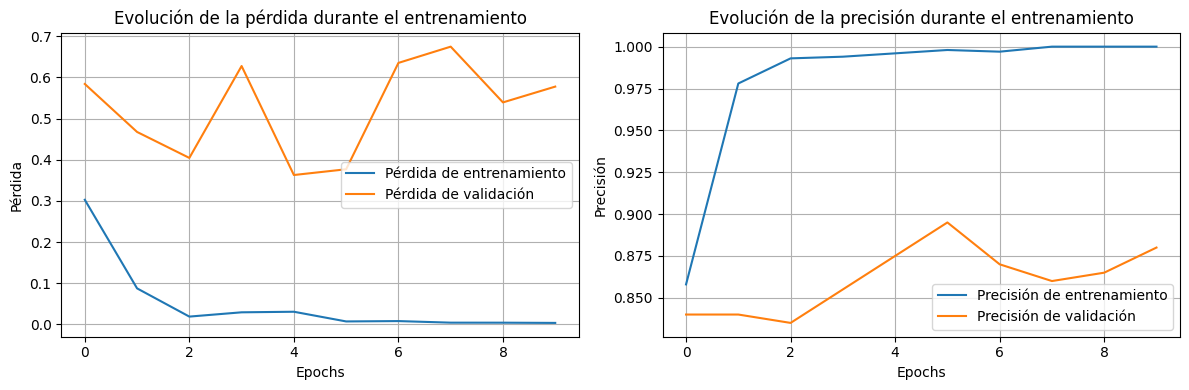

In [25]:
# Grafico la evolucion del modelo durante el entrenamiento
plot_training_history(history)

El modelo, con la misma arquitectura del modelo base, sufre un sobreajuste al conjunto de entrenamiento bastante notable.Por otro lado, la precisión del modelo en el conjunto de validación es notablemente inferior que la obtenida con el modelo base entrenado con el conjunto de entrenamiento y validación completos.

---

<br>
<br>
<br>

### Inferencia

In [26]:
# Genero predicciones para el conjunto de prueba
y_pred = model2.predict(test_data)
y_pred = [1 if p >= 0.5 else 0 for p in y_pred]

conf_matrix = confusion_matrix(test_data.classes, y_pred)
class_report = classification_report(test_data.classes, y_pred)

print(conf_matrix)
print(class_report)

26/26 [==============================] - 1s 57ms/step
[[155 113]
 [ 85 153]]
              precision    recall  f1-score   support

           0       0.65      0.58      0.61       268
           1       0.58      0.64      0.61       238

    accuracy                           0.61       506
   macro avg       0.61      0.61      0.61       506
weighted avg       0.61      0.61      0.61       506



In [27]:
## MÉTRICAS DE CLASIFICACIÓN

print(f"F1-Score ==> {round(f1_score(test_data.labels, y_pred), 3)}")
print(f"Recall ==> {round(recall_score(test_data.labels, y_pred), 3)}")
print(f"Precision ==> {round(precision_score(test_data.labels, y_pred), 3)}")
print(f"Accuracy ==> {round(accuracy_score(test_data.labels, y_pred), 3)}")

F1-Score ==> 0.607
Recall ==> 0.643
Precision ==> 0.575
Accuracy ==> 0.609


Los resultados del modelo con un dataset de entrenamiento de 1000 imágenes es bastante pobre. Para este caso, el modelo base normal ha sido entrenado con 9000 instancias de entrenamiento, logrando una precisión muy buena para la sencillez de su arquitectura. En este caso, podemos confirmar que 1000 instancias son demasiado pocas para lograr un rendimiento óptimo en el conjunto de entrenamiento.

Para esta afirmación, me baso en la misma arquitectura del modelo base; es posible que haciendo algunos ajustes logremos obtener un mejor rendimiento (sobre todo, con una red residual, aprovechando su conocimiento preaprendido).

Por otro lado, el modelo ha tardado muy poco en mostrar indicios claros de **sobreajuste** (estos son notables desde la primera época de entrenamiento), por lo que descartamos la idea de entrenar el modelo base con pocas instancias de datos.